In [ ]:
#importing all necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

# Data (CIFAR-10)

In [ ]:
# creating a data transformation chain
transforms = transforms.Compose([transforms.Resize(224), transforms.Pad(8, padding_mode='reflect'), transforms.RandomCrop(224), transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

# initializing the batch size
batch_size = 224

#importing training and testing sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_count = len(classes)

100%|██████████| 170498071/170498071 [00:13<00:00, 12739858.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


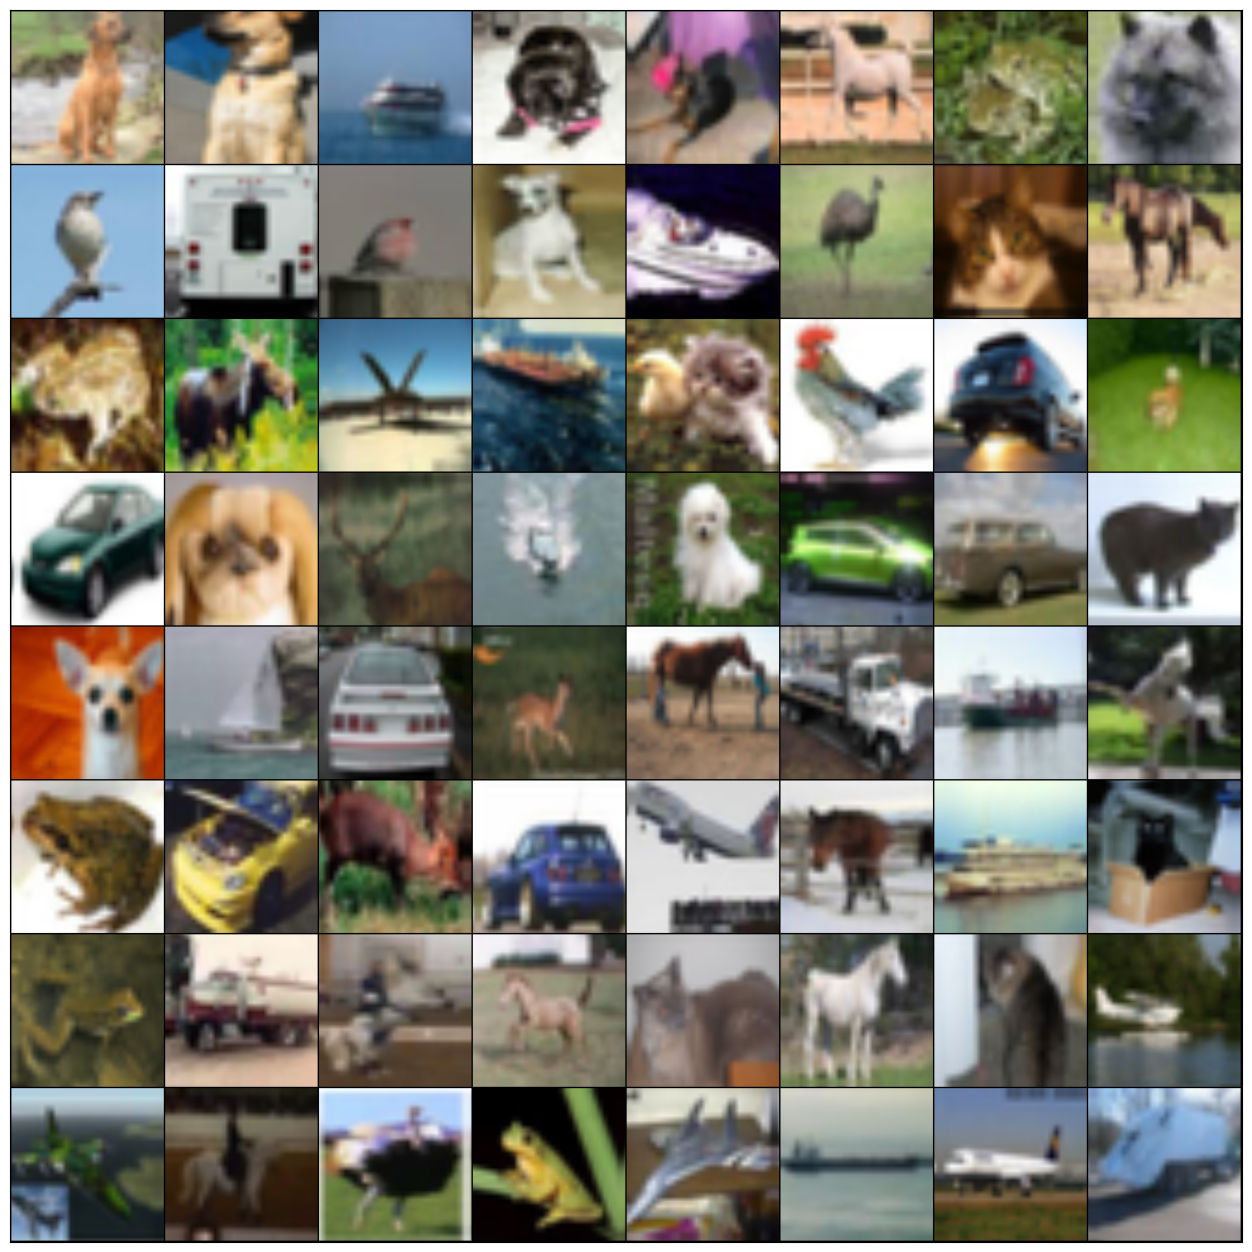

In [ ]:
for images, labels in trainloader:
  fig, ax = plt.subplots(figsize=(16, 16))
  ax.set_xticks([])
  ax.set_yticks([])
  if len(images.shape) == 3:
    images = images.unsqueeze(0)
  means = torch.tensor((0.4914, 0.4822, 0.4465)).reshape(1, 3, 1, 1)
  stds = torch.tensor((0.247, 0.243, 0.261)).reshape(1, 3, 1, 1)
  images = images * stds + means
  ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
  break

# Model Architecture

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        lr_str = "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else ''
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, lr_str, result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
class Cifar10Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        self.network = models.resnet18(pretrained=pretrained)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, l):
        return self.network(l)

    def get_feature_1(self, l):
        return self.network.layer1(net.maxpool(net.relu(net.bn1(net.conv1(l)))))

    def get_feature_2(self,l):
        return self.network.layer2(self.get_feature_1(l))

    def get_feature_3(self, l):
        return self.network.layer3(self.get_feature_2(l))

    def get_feature_4(self, l):
        return self.network.layer4(self.get_feature_3(l))

In [ ]:
def get_default_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
@torch.no_grad()
def evaluate(model, testloader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in testloader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, trainloader, testloader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(trainloader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, testloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, trainloader, testloader,weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(trainloader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(trainloader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
               nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        result = evaluate(model, testloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(trainloader, device)
valid_dl = DeviceDataLoader(testloader, device)

model = Cifar10Model(len(trainset.classes))
to_device(model, device)
model.network.layer1
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.6380343437194824, 'val_acc': 0.10073757916688919}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip,weight_decay=weight_decay, opt_func=opt_func)

  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00279, train_loss: 0.6952, val_loss: 1.4533, val_acc: 0.5440


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00759, train_loss: 0.7950, val_loss: 1.3197, val_acc: 0.5516


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.01000, train_loss: 0.7995, val_loss: 1.0930, val_acc: 0.6127


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00950, train_loss: 0.7322, val_loss: 1.2505, val_acc: 0.5826


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00812, train_loss: 0.6513, val_loss: 0.7407, val_acc: 0.7459


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00611, train_loss: 0.5723, val_loss: 0.6635, val_acc: 0.7664


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00389, train_loss: 0.4836, val_loss: 0.6086, val_acc: 0.7941


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00188, train_loss: 0.3793, val_loss: 0.4582, val_acc: 0.8418


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00050, train_loss: 0.2744, val_loss: 0.3694, val_acc: 0.8762


  0%|          | 0/224 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00000, train_loss: 0.2051, val_loss: 0.3530, val_acc: 0.8812


In [ ]:
labels = []
features_4 = []
features_3 = []
features_2 = []
features_1 = []
limit = 12
with torch.no_grad():
    for cnt, (data, target) in enumerate(tqdm(valid_dl)):
        if cnt >= limit:
            break
        labels.extend(target.detach().cpu().tolist())
        features_4.append(model.get_feature_4(data).detach().cpu())
        features_3.append(model.get_feature_3(data).detach().cpu())
        features_2.append(model.get_feature_2(data).detach().cpu())
        features_1.append(model.get_feature_1(data).detach().cpu())

labels = np.array(labels)
features_4 = torch.cat(features_4, dim=0)
features_3 = torch.cat(features_3, dim=0)
features_2 = torch.cat(features_2, dim=0)
features_1 = torch.cat(features_1, dim=0)

  0%|          | 0/23 [00:00<?, ?it/s]

Feature 4


Feature 1



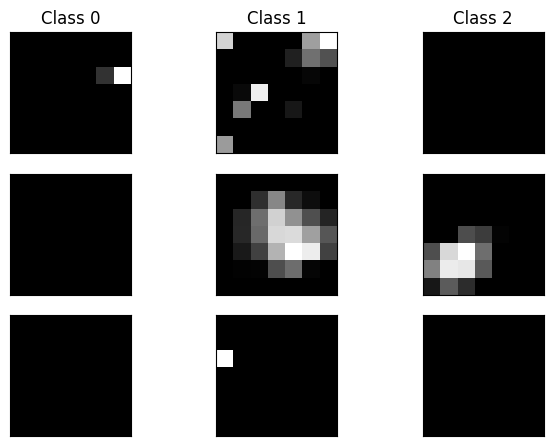

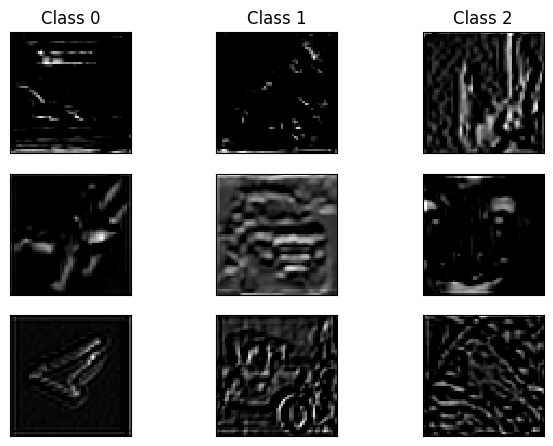

In [ ]:
def feat(features):
  index = 0
  show_class = show_num = 3
  label_counter = [0 for i in range(show_class)]
  fig = plt.figure()
  while index<len(labels):
      c = labels[index]
      if c<show_class and label_counter[c]<show_num:
          plt.subplot(show_num, show_class, show_class*label_counter[c]+c+1)
          plt.tight_layout()
          try:
            plt.imshow(features[index][random.randint(0,512)], cmap='gray', interpolation='none')
          except:
            plt.imshow(features[index][random.randint(0,63)], cmap='gray', interpolation='none')
          if label_counter[c]==0:
              plt.title("Class {}".format(c))
          plt.xticks([])
          plt.yticks([])
          label_counter[c] += 1
      if np.sum(label_counter)==show_class*show_num:
          break
      index += 1

print(f"Feature 4\n")
feat(features_4)
print(f"\nFeature 1\n")
feat(features_1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5376 samples in 0.052s...
[t-SNE] Computed neighbors for 5376 samples in 8.545s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5376
[t-SNE] Computed conditional probabilities for sample 2000 / 5376
[t-SNE] Computed conditional probabilities for sample 3000 / 5376
[t-SNE] Computed conditional probabilities for sample 4000 / 5376
[t-SNE] Computed conditional probabilities for sample 5000 / 5376
[t-SNE] Computed conditional probabilities for sample 5376 / 5376
[t-SNE] Mean sigma: 14.730053
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.986031
[t-SNE] KL divergence after 1000 iterations: 1.881316
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5376 samples in 0.390s...
[t-SNE] Computed neighbors for 5376 samples in 58.412s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5376
[t-SNE] Computed conditional probabilities for sample 2000 / 5376
[t-SNE] Computed conditiona

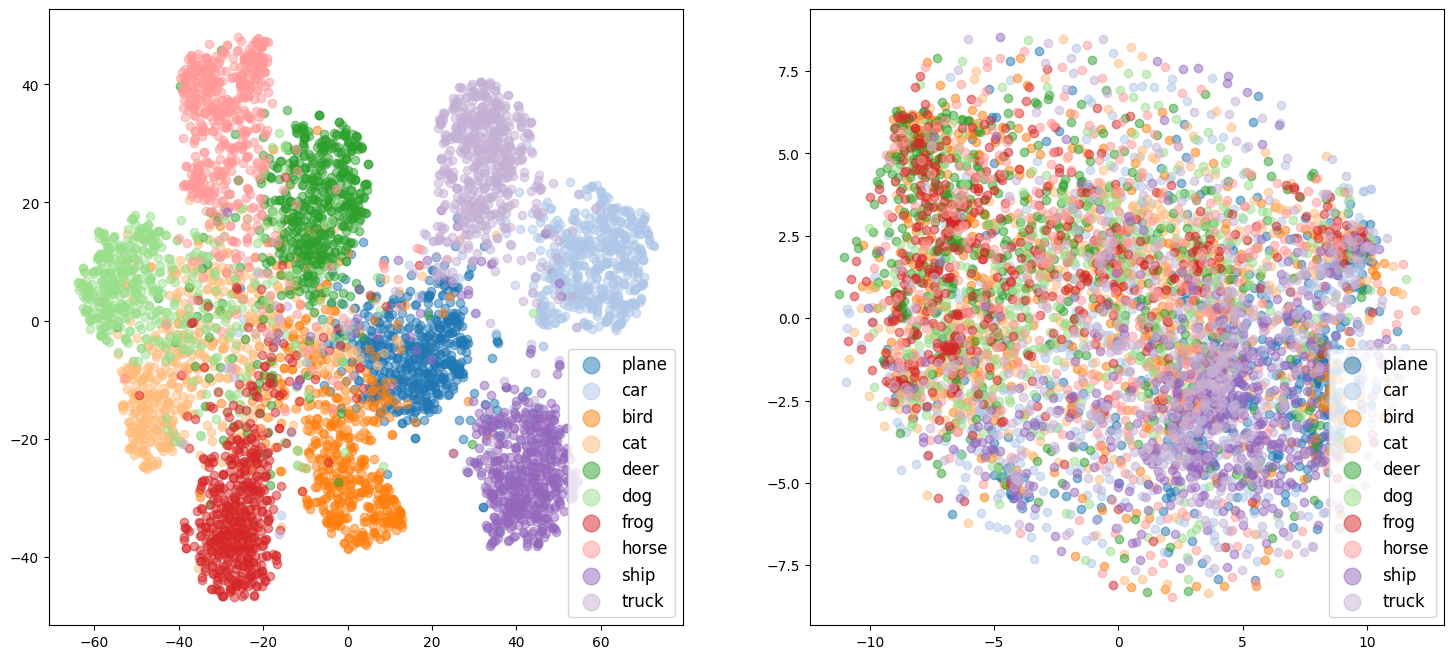

In [ ]:
tsne = TSNE(2, verbose=1)
tsne_proj4 = tsne.fit_transform(features_4.view(features_4.shape[0],-1))
tsne_proj1 = tsne.fit_transform(features_1.view(features_1.shape[0],-1))

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(ncols=2,figsize=(18,8))
num_categories = 10
for lab in range(num_categories):
    indices = labels==lab
    ax[0].scatter(tsne_proj4[indices,0],tsne_proj4[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax[1].scatter(tsne_proj1[indices,0],tsne_proj1[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax[0].legend(fontsize='large', markerscale=2,labels=classes)
ax[1].legend(fontsize='large', markerscale=2,labels=classes)
plt.show()

In [ ]:
def variance(tsne_proj):
  data_points = [np.zeros((2,1)) for i in range(10)]
  for j in range(len(labels)):
      for k in range(10):
          if labels[j] == k:
              data_points[k] = np.append(data_points[k],tsne_proj[j].reshape(2,1),axis=1)
              break
  intra_variance = [0 for i in range(10)]
  inter_variance = [0 for i in range(10)]
  for k in range(10):
      intra_variance[k] = sum(np.var(data_points[k], axis=1))
      print(f"Intra-Variance of class {classes[k]}: {intra_variance[k]}")
  for i in range(1,10):
    inter_variance = sum(np.var(np.append(data_points[0],data_points[i],axis=1), axis=1))
    print(f"Inter-Variance of classes {classes[0]} and {classes[i]}: {inter_variance}")

print(f"Inter and intra variance of for Feature 4\n")
variance(tsne_proj4)
print(f"\nInter and intra variance of for Feature 1\n")
variance(tsne_proj1)

Inter and intra variance of for Feature 4

Intra-Variance of class plane: 142.68824384290104
Intra-Variance of class car: 209.96556016511587
Intra-Variance of class bird: 293.73301549198095
Intra-Variance of class cat: 343.16707253627743
Intra-Variance of class deer: 213.7105957088935
Intra-Variance of class dog: 350.3189401315226
Intra-Variance of class frog: 185.670762690693
Intra-Variance of class horse: 249.06967935189823
Intra-Variance of class ship: 200.91986753887494
Intra-Variance of class truck: 231.77372695217426
Inter-Variance of classes plane and car: 642.172770141553
Inter-Variance of classes plane and bird: 355.07772682718354
Inter-Variance of classes plane and cat: 875.8773934110329
Inter-Variance of classes plane and deer: 460.17515226408113
Inter-Variance of classes plane and dog: 1145.2758962539053
Inter-Variance of classes plane and frog: 740.5634968162866
Inter-Variance of classes plane and horse: 997.8896862186845
Inter-Variance of classes plane and ship: 402.72516